In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print(tf.__version__)

In [16]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
import numpy as np
from matplotlib import pyplot
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display
%matplotlib inline
import random

# %tensorflow_version 1.x
import tensorflow as tf

seed = 1203
np.random.seed(seed)
random.seed(seed)
# tf.random.set_random_seed(seed)
# tf.random.set_seed(seed)

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split

# Data Class Weight
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard



def FER_Model(input_shape):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    #             LSTM Version            #
    # net = layers.LSTM(10, return_sequences=False)(visible)
    net = layers.Dense(64, activation='relu')(visible)
    # net = layers.Dropout(0.2)(net)


    # net = layers.LSTM(5, return_sequences=True)(net)
    net = layers.Dense(32, activation='relu')(net)
    net = layers.Dropout(0.2)(net)

    # net = layers.LSTM(5, return_sequences=True)(visible)
    # net = layers.Dense(16, activation='relu')(net)
    # # net = layers.Dropout(0.2)(net)

    # net = layers.LSTM(1, return_sequences=False)(visible)
    # net = layers.Dense(8, activation='relu')(net)
    # net = layers.Dropout(0.5)(net)

    # net = layers.Conv2D(64, kernel_size=3, padding='same')(visible)
    # net = layers.Activation('relu')(net)
    # net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    # shortcut_1 = net

    # net = layers.Conv2D(32, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    # net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    # shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)
    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs =visible, outputs = net)
    # summary layers
    print(model.summary())
    
    return model


num_classes = 2
batch_size = 80

gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/'

model_range = range(416, 417) # <-- For Training_Size
train_size = [1/8, 2/8, 4/8, 1] # --> test_size is fixed to 2000
break

for model_num in model_range:

  # try:

    Made_X_ = np.load(gdrive_path + 'Made_X/Made_X 30_%s.npy' % (model_num))
    Made_Y = np.load(gdrive_path + 'Made_X/Made_Y 30_%s.npy' % (model_num)).reshape(-1, 1)


    #         Feature Selection      #
    # Made_X = Made_X_[:, :, [-4]]
    Made_X = Made_X_[:, :, :4]
    print(Made_X.shape)
    print(Made_Y.shape)
    # break

    row = Made_X.shape[1]
    col = Made_X.shape[2]

    X_train_, X_val, Y_train_, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
                                                        shuffle=False)
    
    train_len = len(X_train_)

    label_ = Y_train_.reshape(-1, )
       # print(label.shape)

    Y_train_ = np_utils.to_categorical(Y_train_, num_classes)
    Y_val = np_utils.to_categorical(Y_val, num_classes)


    #           Producing Training Size Rebalance        #
    for size_i in range(len(train_size)):


      #         Varibate 변수들만 for loop 내부에 존재해야한다.     #
      specific_num = size_i

      # X_train = X_train.astype('float32') #.reshape(-1, input_data_length, col, 1)
      # X_val = X_val.astype('float32') #.reshape(-1, input_data_length, col, 1)

      X_train = X_train_[-int(train_len * train_size[size_i]):]
      print('X_train.shape :', X_train.shape)
      print('X_val.shape :', X_val.shape)

      Y_train = Y_train_[-int(train_len * train_size[size_i]):]      
      # print(Y_train[:, 0])
      
      print('Y_train.shape :', Y_train.shape)
      print('Y_val.shape :', Y_val.shape)

      label = label_[-int(train_len * train_size[size_i]):]      

      
      #         Get Class_Weights (--> should be considered only for TrainSet)       #
      class_weights = class_weight.compute_class_weight('balanced', 
                                                        classes=np.unique(label),
                                                        y=label)
      
      class_weights = dict(enumerate(class_weights))
      print(class_weights)
      # quit()


      model = FER_Model((row, col))
      opt = Adam(lr=0.0001, decay=1e-6)

      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        
          
      filepath = gdrive_path + "model/rapid_ascending %s_%s_futures_rnn.hdf5" % (model_num, specific_num)
      checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
      checkpoint2 = TensorBoard(log_dir='Tensorboard_graph',
                                histogram_freq=0,
                                write_graph=True,
                                write_images=True)
      checkpoint3 = EarlyStopping(monitor='val_accuracy', patience=100)
      callbacks_list = [checkpoint, checkpoint2, checkpoint3]

      # keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

      # we iterate 200 times over the entire training set
      num_epochs = 1000
      history = model.fit(X_train, Y_train,
                          steps_per_epoch=int(len(X_train) / batch_size), 
                          epochs=num_epochs,  
                          verbose=2,  
                          callbacks=callbacks_list,
                          class_weight=class_weights,
                          validation_data=(X_val, Y_val),  
                          validation_steps=int(len(X_val) / batch_size),
                          shuffle=False)
    
  # except Exception as e:
  #   print('Error occured :', e)


(10375, 30, 4)
(10375, 1)
X_train.shape : (907, 30, 4)
X_val.shape : (3113, 30, 4)
Y_train.shape : (907, 2)
Y_val.shape : (3113, 2)
{0: 0.6987673343605547, 1: 1.7577519379844961}
Model: "functional_361"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 4)]           0         
_________________________________________________________________
dense_720 (Dense)            (None, 30, 64)            320       
_________________________________________________________________
dense_721 (Dense)            (None, 30, 32)            2080      
_________________________________________________________________
dropout_180 (Dropout)        (None, 30, 32)            0         
_________________________________________________________________
flatten_180 (Flatten)        (None, 960)               0         
_________________________________________________________________
dense

### ***Backtest***

Made_X.shape : (10239, 30, 4)
Made_Y.shape : (10239, 1)
Made_X_test.shape : (2701, 30, 4)
Made_Z_test.shape : (2701, 4)
X_train.shape : (895, 30, 4)
X_val.shape : (3072, 30, 4)
model_num : 384 specific_num : 0
Pred by Real
18/18 [==============================] - 0s 2ms/step - loss: 0.4757 - accuracy: 0.7765


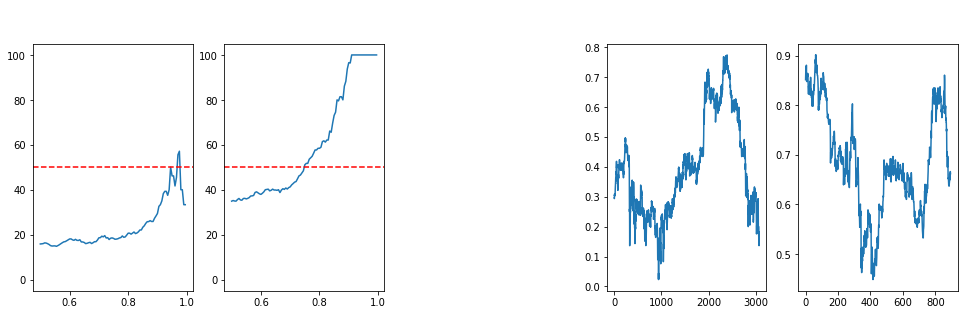

X_train.shape : (1791, 30, 4)
X_val.shape : (3072, 30, 4)
model_num : 384 specific_num : 1
Pred by Real
36/36 [==============================] - 0s 2ms/step - loss: 0.6775 - accuracy: 0.7973


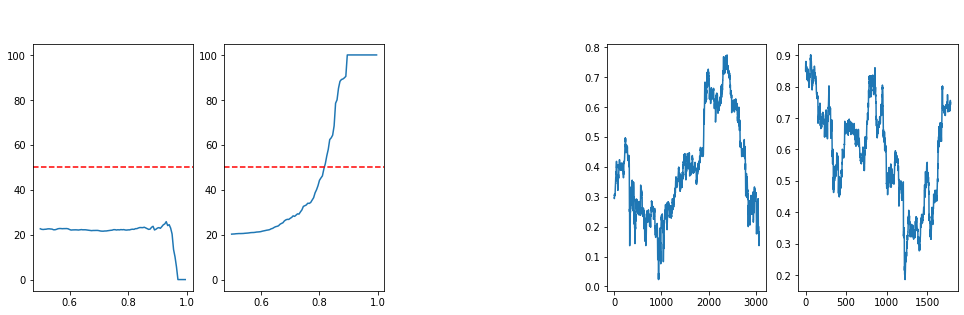

X_train.shape : (3583, 30, 4)
X_val.shape : (3072, 30, 4)
model_num : 384 specific_num : 2
Pred by Real
71/71 [==============================] - 0s 2ms/step - loss: 0.6625 - accuracy: 0.7949


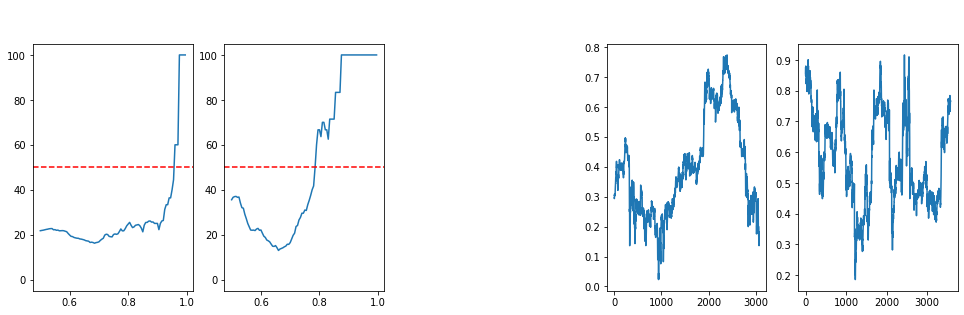

X_train.shape : (7167, 30, 4)
X_val.shape : (3072, 30, 4)
model_num : 384 specific_num : 3
Pred by Real
141/141 [==============================] - 0s 2ms/step - loss: 0.6705 - accuracy: 0.7883


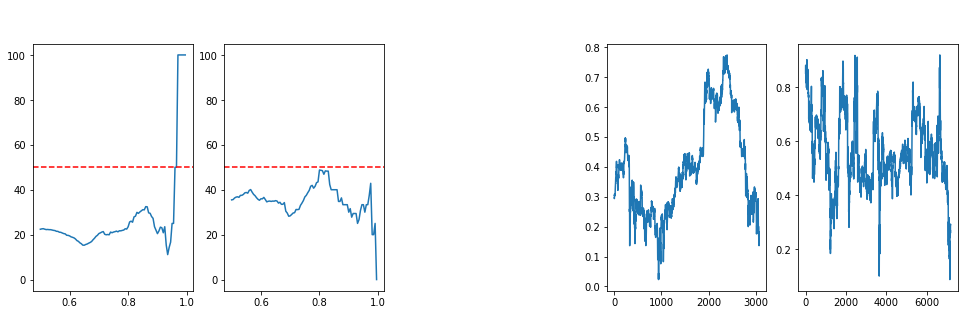

Made_X.shape : (10280, 30, 4)
Made_Y.shape : (10280, 1)
Made_X_test.shape : (2701, 30, 4)
Made_Z_test.shape : (2701, 4)
X_train.shape : (899, 30, 4)
X_val.shape : (3084, 30, 4)
model_num : 385 specific_num : 0
Pred by Real
18/18 [==============================] - 0s 2ms/step - loss: 0.6785 - accuracy: 0.7119


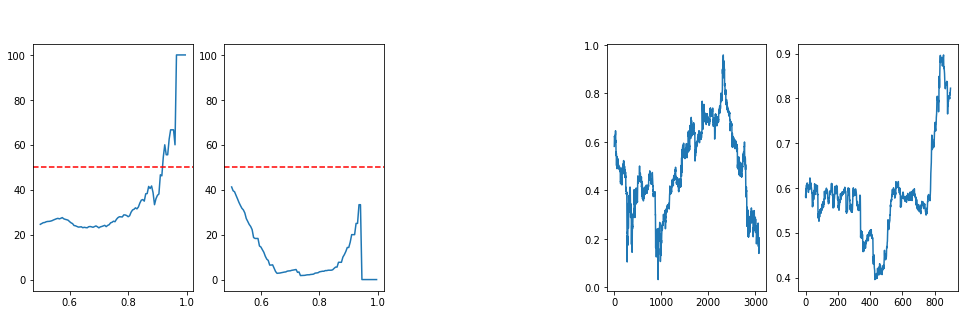

X_train.shape : (1799, 30, 4)
X_val.shape : (3084, 30, 4)
model_num : 385 specific_num : 1
Pred by Real
36/36 [==============================] - 0s 2ms/step - loss: 0.6834 - accuracy: 0.6170


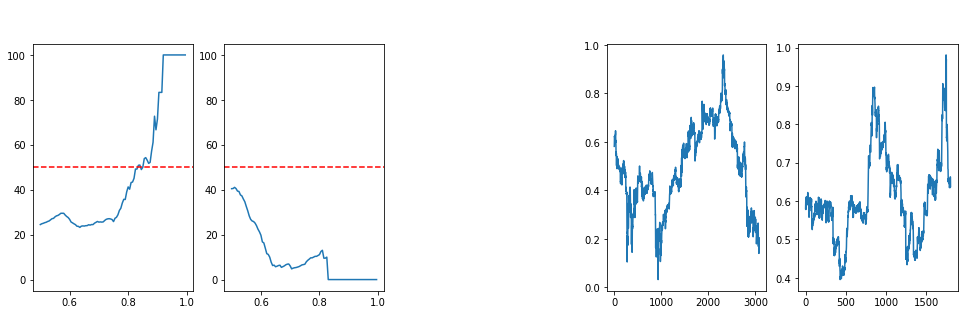

X_train.shape : (3598, 30, 4)
X_val.shape : (3084, 30, 4)
model_num : 385 specific_num : 2
Pred by Real
71/71 [==============================] - 0s 2ms/step - loss: 0.6714 - accuracy: 0.6648


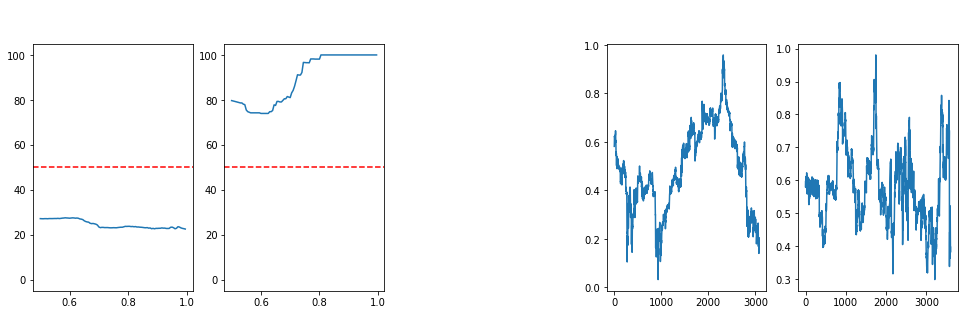

X_train.shape : (7196, 30, 4)
X_val.shape : (3084, 30, 4)
model_num : 385 specific_num : 3
Pred by Real
142/142 [==============================] - 0s 2ms/step - loss: 0.6871 - accuracy: 0.7069


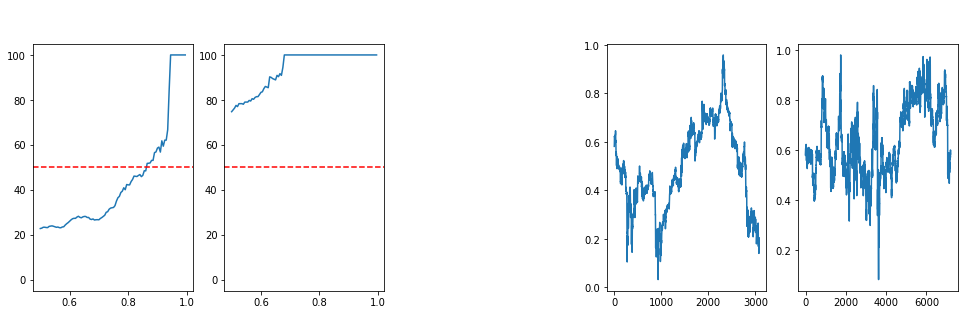

Made_X.shape : (10204, 30, 4)
Made_Y.shape : (10204, 1)
Made_X_test.shape : (2701, 30, 4)
Made_Z_test.shape : (2701, 4)
X_train.shape : (892, 30, 4)
X_val.shape : (3062, 30, 4)
model_num : 386 specific_num : 0
Pred by Real
18/18 [==============================] - 0s 2ms/step - loss: 0.6277 - accuracy: 0.8330


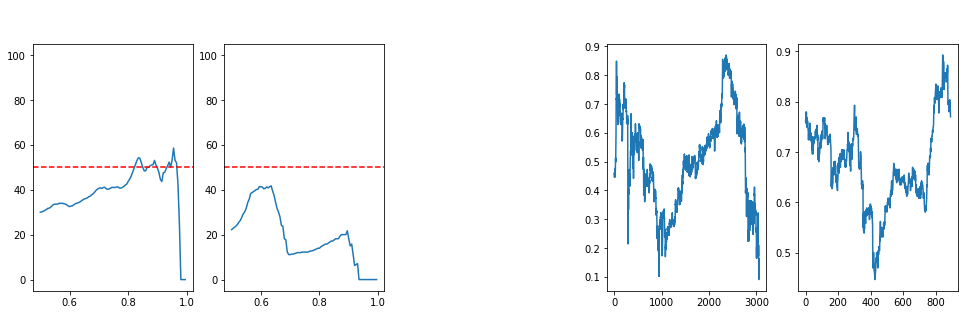

X_train.shape : (1785, 30, 4)
X_val.shape : (3062, 30, 4)
model_num : 386 specific_num : 1
Pred by Real
35/35 [==============================] - 0s 2ms/step - loss: 0.7009 - accuracy: 0.2588


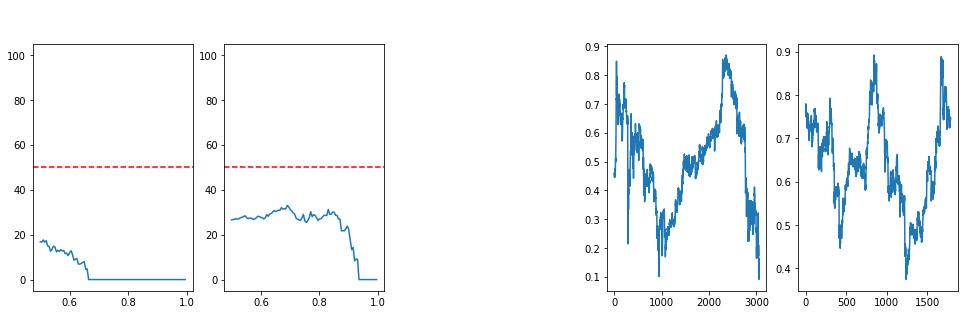

X_train.shape : (3571, 30, 4)
X_val.shape : (3062, 30, 4)
model_num : 386 specific_num : 2
Pred by Real
71/71 [==============================] - 0s 2ms/step - loss: 0.6762 - accuracy: 0.7292


KeyboardInterrupt: ignored

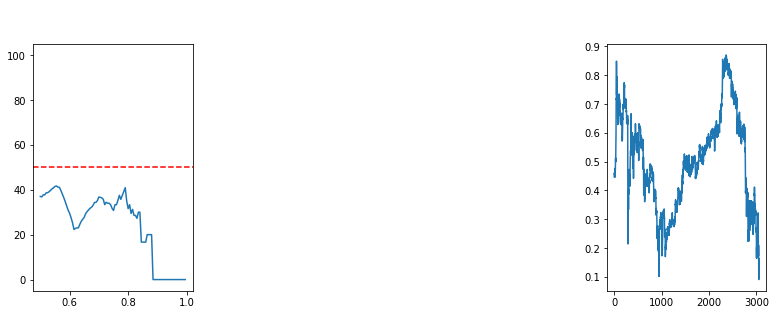

In [12]:
#     Confidence value should be adjusted by min max scale in y_pred    #
from keras.models import load_model
import matplotlib.pyplot as plt


trade_on = True
show_trade_data = False

input_data_length = 30
for model_num in model_range:

  # try:

    Made_X_ = np.load(gdrive_path + 'Made_X/Made_X 30_%s.npy' % model_num)
    Made_Y = np.load(gdrive_path + 'Made_X/Made_Y 30_%s.npy' % model_num).reshape(-1, 1)

    Made_X_test_ = np.load(gdrive_path + 'Made_X/Made_X %s_%s.npy' % (input_data_length, model_num + 40))
    #     for trade, ohlc data    #
    Made_Z_test = np.load(gdrive_path + 'Made_X/Made_Z %s_%s.npy' % (input_data_length, model_num + 40))

    #         Feature Selection      #
    # Made_X = Made_X_[:, :, [-4]]
    Made_X = Made_X_[:, :, :4]
    Made_X_test = Made_X_test_[:, :, :4]
    print('Made_X.shape :', Made_X.shape)
    print('Made_Y.shape :', Made_Y.shape)
    print('Made_X_test.shape :', Made_X_test.shape)
    print('Made_Z_test.shape :', Made_Z_test.shape)

    # print('min(Made_Z_test) :', np.min(Made_Z_test))
    # break

    row = Made_X.shape[1]
    col = Made_X.shape[2]

    X_train_, X_val, Y_train_, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
                                                        shuffle=False)
    X_test = Made_X_test

    Y_train_ = np_utils.to_categorical(Y_train_, num_classes)
    Y_val = np_utils.to_categorical(Y_val, num_classes)
    train_len = len(X_train_)


    #           Producing Training Size Rebalance        #
    for size_i in range(len(train_size)):


      #         Varibate 변수들만 for loop 내부에 존재해야한다.     #
      specific_num = size_i

      # X_train = X_train.astype('float32') #.reshape(-1, input_data_length, col, 1)
      # X_val = X_val.astype('float32') #.reshape(-1, input_data_length, col, 1)

      X_train = X_train_[-int(train_len * train_size[size_i]):]
      print('X_train.shape :', X_train.shape)
      print('X_val.shape :', X_val.shape)

      Y_train = Y_train_[-int(train_len * train_size[size_i]):]      

      
      for model_i, model_num in enumerate([model_num]):

        print('model_num :', model_num, 'specific_num :', specific_num)
        if model_i == 0:
          print('Pred by Real')
        else:
          print('Pred by None Real')

        model_path = gdrive_path + "model/rapid_ascending %s_%s_futures_rnn.hdf5" % (model_num, specific_num)
        model = load_model(model_path)

        #     val, train -> confidence 와 evaluate 용
        val_y_pred_ = model.predict(X_val, verbose=1)
        train_y_pred_ = model.predict(X_train, verbose=1)

        #     test -> profit 용
        test_y_pred_ = model.predict(X_test, verbose=1)

        plt.figure(figsize=(20, 10))
        
        for index, y_pred_ in enumerate([val_y_pred_, train_y_pred_, test_y_pred_]):

          # print('len(y_pred_) :', len(y_pred_))
          target_column = y_pred_[:, [-1]]
          # column_min, column_max = train_y_pred_.min(),train_y_pred_.max()
          column_min, column_max = target_column.min(),target_column.max()
          # print(column_min, column_max)

          if index == 0:
            _, model_acc = model.evaluate(X_val, Y_val, batch_size=batch_size)
          elif index == 1:
            _, model_acc = model.evaluate(X_train, Y_train, batch_size=batch_size)

          x_ticks = np.arange(0.5, 1, 0.005)
          # x_ticks = [0.6]
          # x_ticks = np.arange(0.5, column_max, 0.005) <-- column_max 대응할만한 값을 찾아야한다. 1 까지는 사용못할것

          confidence_result = list()
          profit_result = list()        
          for confidence in x_ticks:
            # confidence = 0.9

            # if column_max < 0.5:
            #   break
            # else:
            #   scaled_confidence = .5 + (column_max - .5) * confidence
            scaled_confidence = column_min + (column_max - column_min) * confidence
            # scaled_confidence = confidence

            # print(scaled_confidence)
            # print('confidence :', confidence)

            y_pred = np.where(target_column >= scaled_confidence, 1, 0).reshape(-1, )
  
            pred_true, real_true, true_true = 0, 0, 0   

            #     결국, Categorical 은 index 값으로 value 를 나타내는 것    #
            # t_te = np.argmax(Y_test, axis=1)            
            if index == 0:
              t_te = np.argmax(Y_val, axis=1)
            elif index == 1:
              t_te = np.argmax(Y_train, axis=1)

            #       Trading Session, Accumulate Profit     #
            elif index == 2:

              accumulated_profit = 1.

              if trade_on:
                tp_ratio = 3
                target_percentage = 0.05
                sl_least_gap_ratio = 0.05

                long_marker_x = list()
                long_marker_y = list()
                tp_marker_x = list()
                tp_marker_y = list()
                sl_marker_x = list()
                sl_marker_y = list()
                tp_level_list_x = list()
                tp_level_list_y = list()
                sl_level_list_x = list()
                sl_level_list_y = list()

                #         This column order should be changed     #
                high, low, close = np.split(Made_Z_test[:, 1:4], 3, axis=1) # <-- Column Order should be changed
                # break
                i = input_data_length
                while (i < len(y_pred)):

                  #     Long    #
                  if y_pred[i] == 1:  

                    long_sl = np.min(low[i + 1 -input_data_length:i + 1])
                    short_sl = np.max(high[i + 1 -input_data_length:i + 1])
                    tp_level = (close[i] - long_sl) * tp_ratio + close[i]

                    #       Consider 'sl_least_gap'     #
                    if not close[i] >= long_sl + (short_sl - long_sl) * sl_least_gap_ratio:
                      i += 1
                      if i >= len(y_pred):
                        break
                      continue

                    if show_trade_data: print(i, 'long')
                    pred_true += 1

                    long_marker_x.append(i)
                    long_marker_y.append(close[i])

                    if i + 1 >= len(y_pred):
                      break
                    
                    for j in range(i + 1, len(y_pred)):

                      if show_trade_data: print(long_sl, low[j], high[j], tp_level)
                      tp_level_list_x.append(j)
                      tp_level_list_y.append(tp_level)

                      if high[j] > tp_level:
                        accumulated_profit *= 1 + target_percentage * tp_ratio
                        if show_trade_data: print(j, 'tp, accum.profit :', accumulated_profit)  
                        tp_marker_x.append(j)
                        tp_marker_y.append(high[j])
                        real_true += 1
                        break
                      
                      elif low[j] < long_sl:
                        accumulated_profit *= 1 - target_percentage
                        if show_trade_data: print(j, 'tp, accum.profit :', accumulated_profit)          
                        sl_marker_x.append(j)
                        sl_marker_y.append(low[j])
                        break

                    i = j

                  i += 1
                  # print('i, len(y_pred) :', i, len(y_pred))
                  if i >= len(y_pred):
                    break

              profit_result.append(accumulated_profit)

            if index != 2:

              for i in range(len(y_pred)):
                if y_pred[i] == 1:  
                  pred_true += 1
                  if t_te[i] == y_pred[i]:
                    real_true += 1

            if pred_true != 0:
              true_true = real_true / pred_true * 100
            confidence_result.append(true_true)

            # print('Real True / Pred True : %s / %s' % (real_true, pred_true))
            # print('Accuracy : %.2f %%' % (true_true))
            # print('Accumulated Profit : %.3f' % accumulated_profit)
            # print()

          #         Show True True Acc by confidence    #
          plt.subplot(2, 7, index + 1 + model_i * 7)
          plt.plot(x_ticks, confidence_result)
          plt.axhline(50, linestyle='--', color='red')
          plt.ylim(-5, 105)
          plt.title('%s %s \n Model Acc %s \n TT Acc' % (column_min, column_max, model_acc), color='white', fontsize=10)

          #       Show Profit by confidence     #
          if index == 2:
            plt.subplot(2, 7, index + 2 + model_i * 7)
            plt.plot(x_ticks, profit_result)
            plt.axhline(1., linestyle='--', color='red')
            plt.title('%s %s \n Test Profit \n %s %s' % (column_min, column_max, 
                                                         min(profit_result), max(profit_result)), color='white', fontsize=10)

          if index == 0:
            plt.subplot(2, 7, index + 5 + model_i * 7)
            plt.plot(Made_X_[-len(X_val):, [-1], [3]])
          elif index == 1:
            plt.subplot(2, 7, index + 5 + model_i * 7)
            plt.plot(Made_X_[:len(X_train), [-1], [3]])
          elif index == 2:
            plt.subplot(2, 7, index + 5 + model_i * 7)
            plt.plot(Made_Z_test[:, 3])

          #          Show Entry Point       #
          # plt.subplot(2, 1, index + 1 + model_i * 1)
          # plt.plot(close)
          # plt.plot(long_marker_x, long_marker_y, 'o', color='green')             
          # plt.plot(tp_marker_x, tp_marker_y, 'o', color='blue')
          # plt.plot(sl_marker_x, sl_marker_y, 'o', color='red')
          # plt.plot(tp_level_list_x, tp_level_list_y, '.', color='blue')
          # plt.title('Accumulated Profit : %.3f' % accumulated_profit, color='white')
          
        plt.show()

  # except Exception as e:
  #   print('Error occured : ', e)
  # print()
  # break

### ***None Realtime vs Realtime***

Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 2ms/step


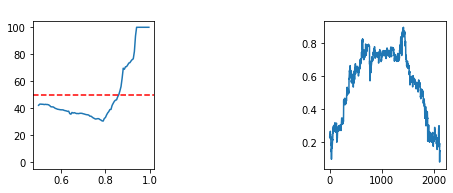

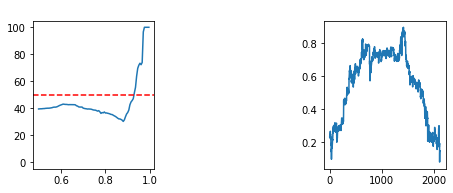


Pred by Real
65/65 [==============================] - 0s 951us/step
Pred by None Real
65/65 [==============================] - 0s 944us/step


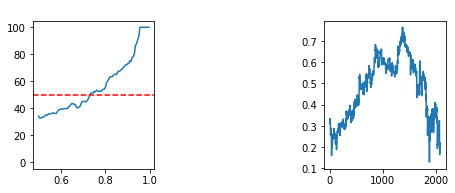

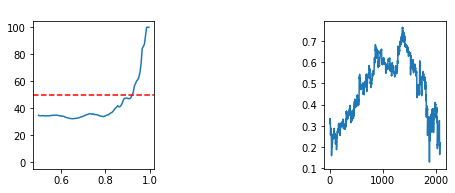


Pred by Real
65/65 [==============================] - 0s 2ms/step
Pred by None Real
65/65 [==============================] - 0s 1ms/step


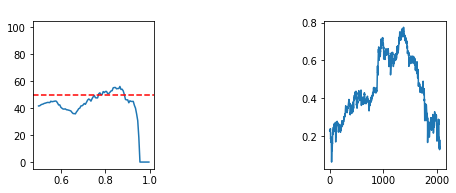

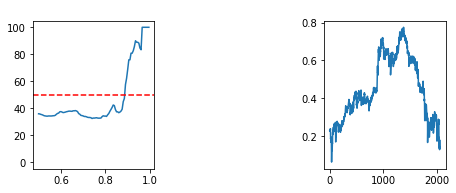


Pred by Real
67/67 [==============================] - 0s 2ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


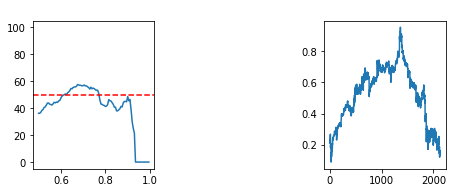

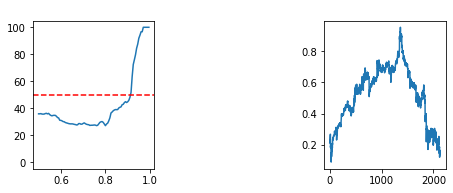


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


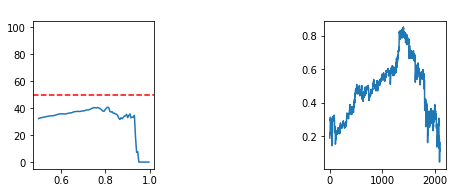

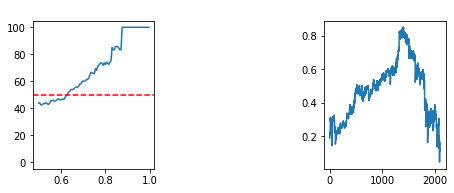


Pred by Real
68/68 [==============================] - 0s 2ms/step
Pred by None Real
68/68 [==============================] - 0s 2ms/step


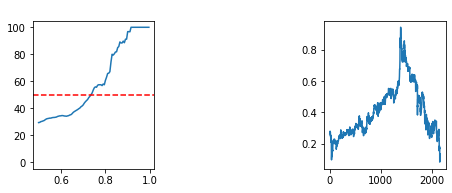

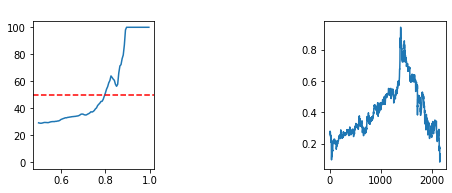


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


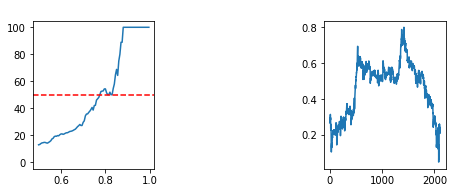

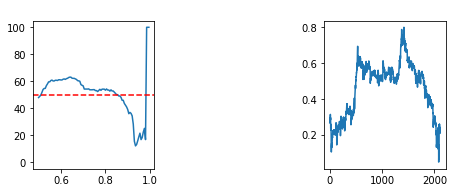


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


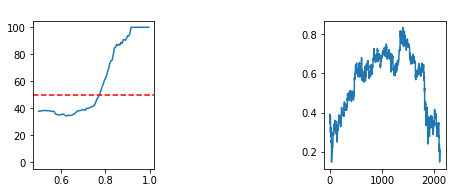

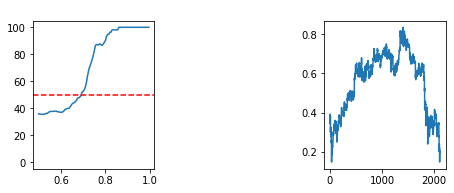


Pred by Real
Error occured :  SavedModel file does not exist at: /content/gdrive/My Drive/Colab Notebooks/Project_Stock/model/rapid_ascending 30_227_futures_rnn.hdf5/{saved_model.pbtxt|saved_model.pb}

Pred by Real
67/67 [==============================] - 0s 2ms/step
Pred by None Real
67/67 [==============================] - 0s 2ms/step


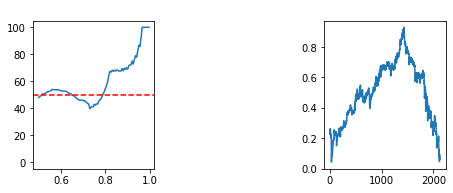

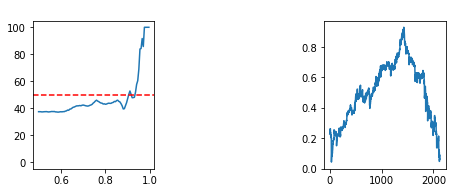


Pred by Real
66/66 [==============================] - 0s 2ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


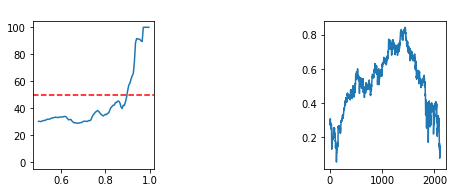

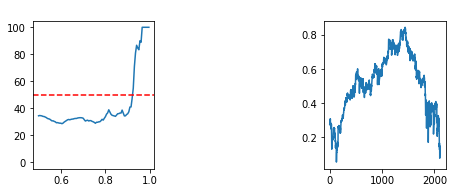


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


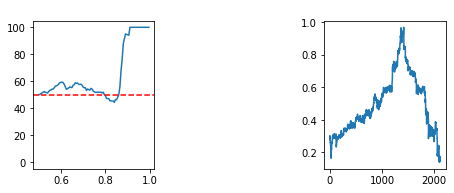

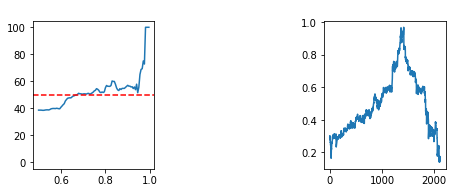


Pred by Real
65/65 [==============================] - 0s 2ms/step
Pred by None Real
65/65 [==============================] - 0s 1ms/step


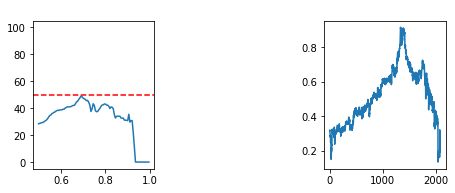

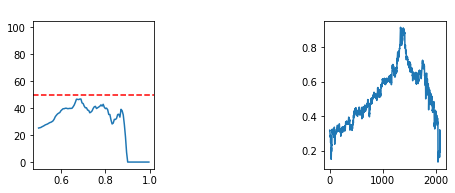


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


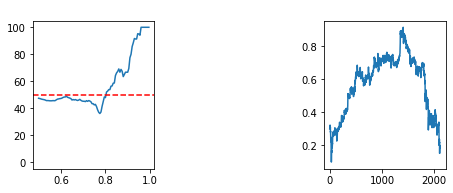

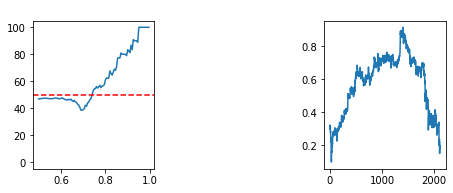


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 2ms/step


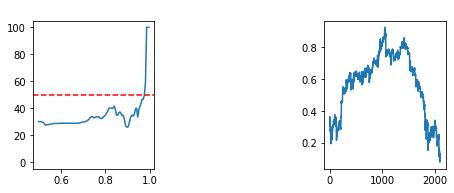

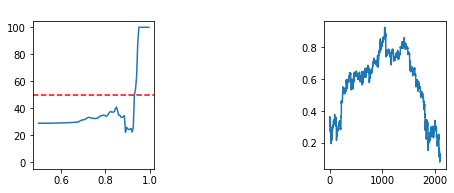


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


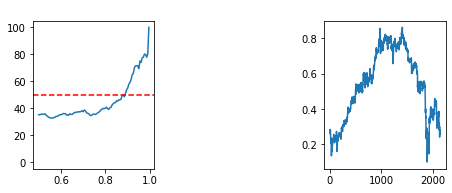

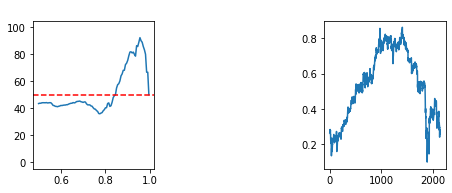


Pred by Real
64/64 [==============================] - 0s 2ms/step
Pred by None Real
64/64 [==============================] - 0s 1ms/step


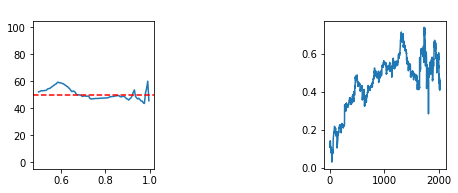

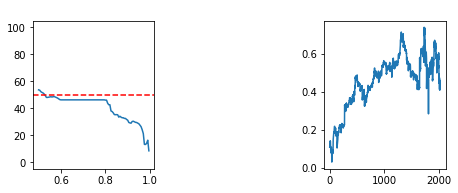


Pred by Real
63/63 [==============================] - 0s 1ms/step
Pred by None Real
63/63 [==============================] - 0s 2ms/step


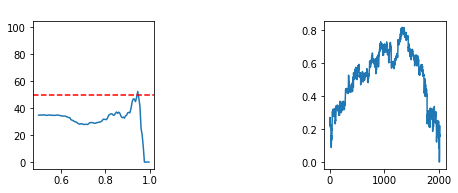

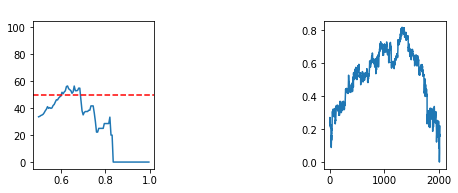


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 2ms/step


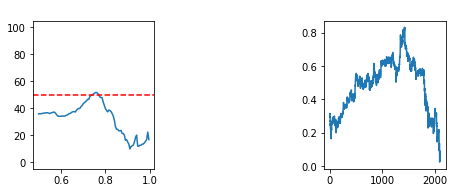

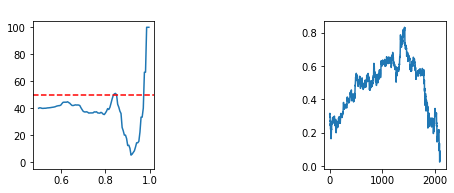


Pred by Real
63/63 [==============================] - 0s 1ms/step
Pred by None Real
63/63 [==============================] - 0s 1ms/step


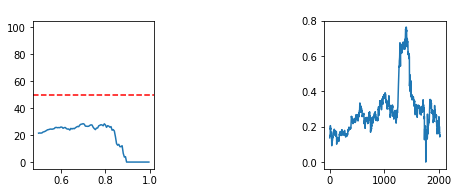

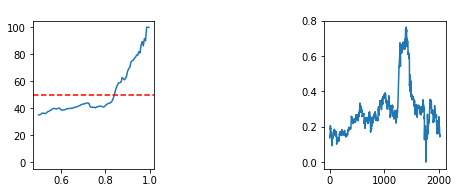


Pred by Real
64/64 [==============================] - 0s 1ms/step
Pred by None Real
64/64 [==============================] - 0s 1ms/step


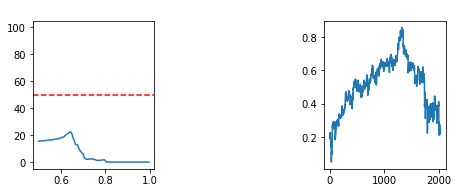

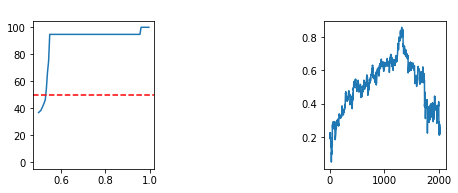


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


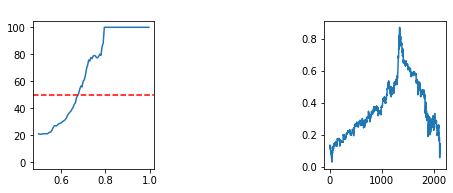

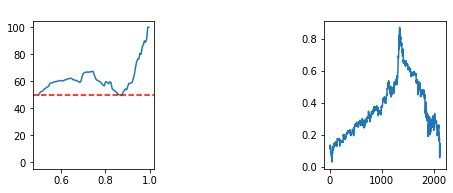


Pred by Real
65/65 [==============================] - 0s 1ms/step
Pred by None Real
65/65 [==============================] - 0s 2ms/step


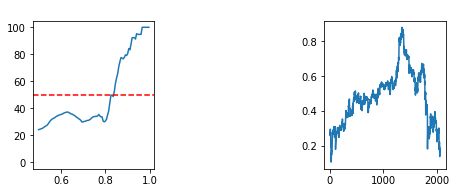

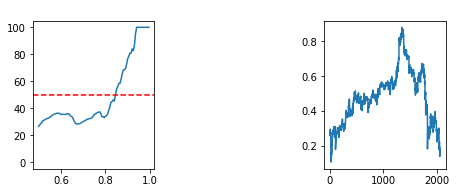


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


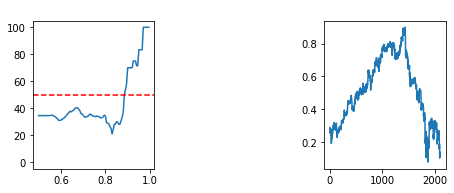

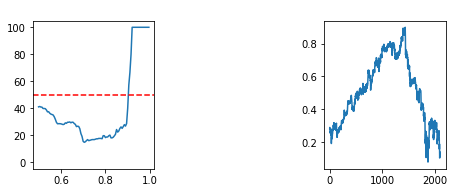


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


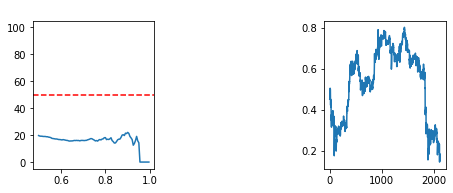

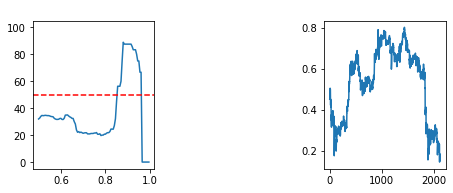


Pred by Real
69/69 [==============================] - 0s 1ms/step
Pred by None Real
69/69 [==============================] - 0s 1ms/step


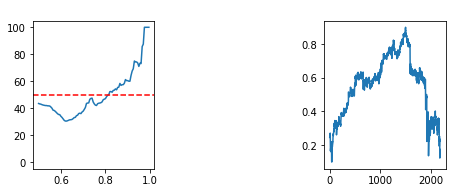

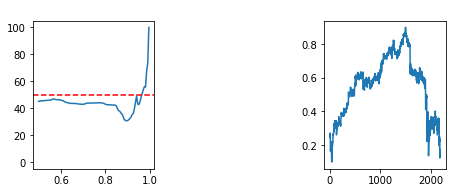


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


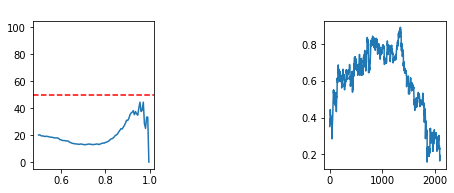

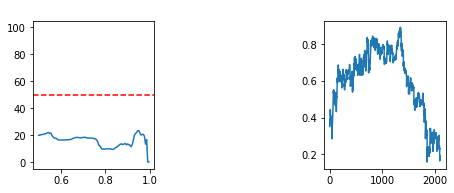


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 2ms/step


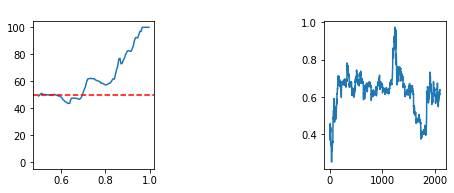

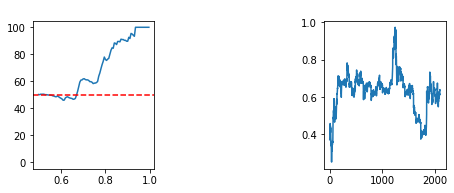


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


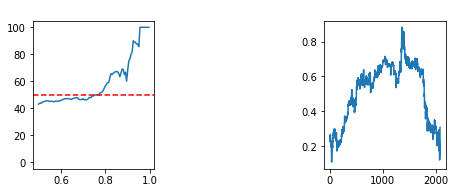

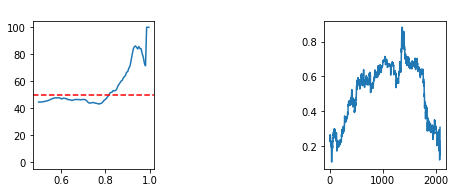


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


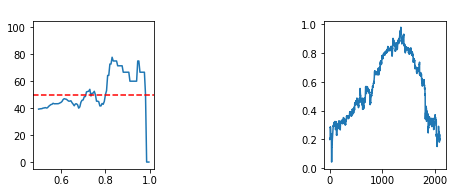

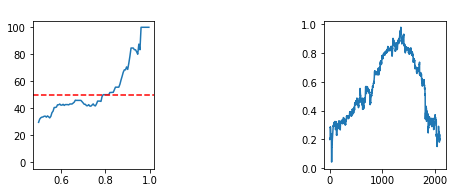


Pred by Real
68/68 [==============================] - 0s 2ms/step
Pred by None Real
68/68 [==============================] - 0s 1ms/step


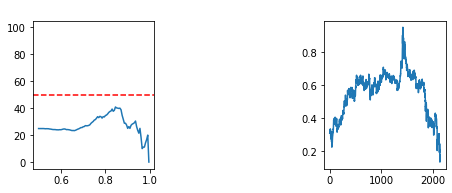

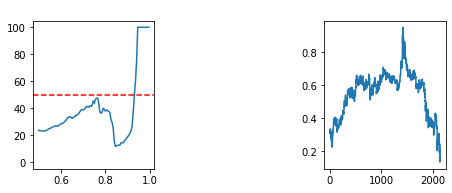


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


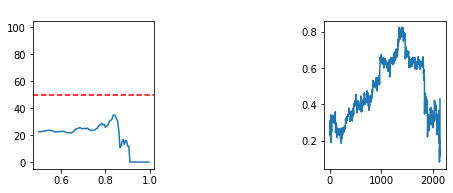

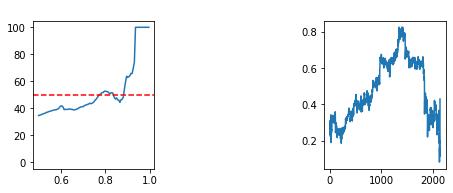


Pred by Real
64/64 [==============================] - 0s 1ms/step
Pred by None Real
64/64 [==============================] - 0s 1ms/step


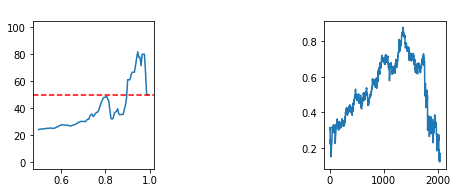

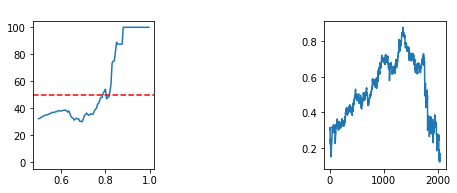


Pred by Real
66/66 [==============================] - 0s 2ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


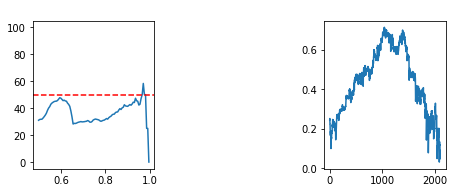

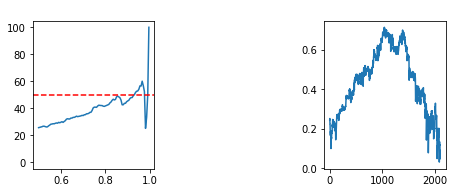


Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_376.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_377.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_378.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_379.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_380.npy'

Pred by Real
Error occured :  SavedModel file does not exist at: /content/gdrive/My Drive/Colab Notebooks/Project_Stock/model/rapid_ascending 30_258_futures_rnn.hdf5/{saved_model.pbtxt|saved_model.pb}

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Ma

In [ ]:
#     Confidence value should be adjusted by min max scale in y_pred    #
from keras.models import load_model
import matplotlib.pyplot as plt

for model_num in model_range:

  try:

    #     Get Test Dataset   #
    Made_X_ = np.load(gdrive_path + 'Made_X/Made_X %s_%s.npy' % (input_data_length, model_num + 41 * 3))
    Made_Y = np.load(gdrive_path + 'Made_X/Made_Y %s_%s.npy' % (input_data_length, model_num + 41 * 3)).reshape(-1, 1)

    #       dataset 분리      #
    # dataX 구성 : VOLUME, MA, CMO, OBV, RSI, MACD, MACD_SIGNAL, MACD_OSC 
    # dataX 구성 : VOLUME, EMA1, EMA2, CMO, OBV, RSI, MACD, MACD_SIGNAL, MACD_OSC 
    # Made_X = Made_X_[:, :, [-4]]
    Made_X = Made_X_[:, :, :4]
    # print(Made_X.shape)
    # print(Made_Y.shape)
    # break

    row = Made_X.shape[1]
    col = Made_X.shape[2]

    # X_train, X_val, Y_train, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
    #                                                   shuffle=False)

    # X_train = X_train.astype('float32')#.reshape(-1, input_data_length, col, 1)
    # X_val = X_val.astype('float32')#.reshape(-1, input_data_length, col, 1)

    X_test = Made_X.astype('float32')
    Y_test = Made_Y
    
    for model_i, model_num in enumerate([model_num, model_num + 41]):

      if model_i == 0:
        print('Pred by Real')
      else:
        print('Pred by None Real')

      model_path = gdrive_path + "model/rapid_ascending %s_%s_futures_rnn.hdf5" % (input_data_length, model_num)
      model = load_model(model_path)
      y_pred_ = model.predict(X_test, verbose=1)
      # total_y_pred_ = model.predict(Made_X, verbose=1)

      plt.figure(figsize=(10, 6))
      
      for index, y_pred_ in enumerate([y_pred_]):

        # print('len(y_pred_) :', len(y_pred_))
        target_column = y_pred_[:, [-1]]
        # column_min, column_max = train_y_pred_.min(),train_y_pred_.max()
        column_min, column_max = target_column.min(),target_column.max()
        # print(column_min, column_max)

        x_ticks = np.arange(0.5, 1, 0.005)
        # x_ticks = np.arange(0.5, column_max, 0.005) <-- column_max 대응할만한 값을 찾아야한다. 1 까지는 사용못할것
        confidence_result = list()
        for confidence in x_ticks:
          # confidence = 0.9

          # if column_max < 0.5:
          #   break
          # else:
          #   scaled_confidence = .5 + (column_max - .5) * confidence
          scaled_confidence = column_min + (column_max - column_min) * confidence

          # scaled_confidence = confidence
          # print(scaled_confidence)
          # print('confidence :', confidence)

          y_pred = np.where(target_column >= scaled_confidence, 1, 0).reshape(-1, )

          #   inverse version   #
          # confidence = 1 - confidence
          # scaled_confidence = y_pred_[:, [-1]].min() + (y_pred_[:, [-1]].max() - y_pred_[:, [-1]].min()) * confidence
          # y_pred = np.where(y_pred_[:, [-1]] <= scaled_confidence, 1, 0).reshape(-1, )

          #     결국, Categorical 은 index 값으로 value 를 나타내는 것    #
          # t_te = np.argmax(Y_val, axis=1)

          t_te = Y_test

          # print(y_pred_[:5])
          # print(Y_val[:5])
          # break

          pred_true = 0
          real_true = 0

          #       predict value 존나 높으면 True 일 확률 존나 높은건데, 그게 진짜 True가 맞냐 이걸 알고 싶은거지     #
          #       confidence를 만족하는 label이 1인 데이터 안에서 pred 1 / label 1 -> 이걸 도출해면 된다        #

          for i in range(len(y_pred)):
            if y_pred[i] == 1:  
              pred_true += 1
              if t_te[i] == y_pred[i]:
                real_true += 1

          true_true = real_true / pred_true * 100
          confidence_result.append(true_true)
          # print('True Pred / Total True : %s / %s' % (real_true, pred_true))
          # print('Accuracy : %2.f %%' % (true_true))
          # print()

        # if column_max < 0.5:
        #   continue
        
        plt.subplot(2, 4, index + 1 + model_i * 4)
        plt.plot(x_ticks, confidence_result)
        plt.axhline(50, linestyle='--', color='red')
        plt.ylim(-5, 105)
        plt.title('%s %s' % ((column_min, column_max)), color='white', fontsize=10)

        if index == 0:
          plt.subplot(2, 4, index + 3 + model_i * 4)
          plt.plot(Made_X_[:, [-1], [3]])
        elif index == 1:
          plt.subplot(2, 4, index + 3 + model_i * 4)
          plt.plot(Made_X_[:, [-1], [3]])

    plt.show()

  except Exception as e:
    print('Error occured : ', e)
  print()


### ***Check Entry points in Chart***

confidence : 0.8


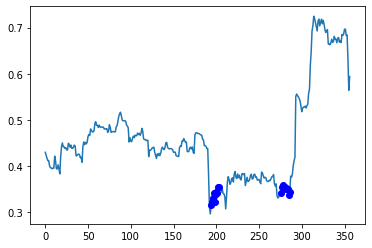

In [ ]:
#     Confidence value should be adjusted by min max scale in y_pred    #
from keras.models import load_model


confidence = 0.8
scaled_confidence = column_min + (column_max - column_min) * confidence
# print(scaled_confidence)
print('confidence :', confidence)

y_pred = np.where(target_column >= scaled_confidence, 1, 0).reshape(-1, )
t_te = np.argmax(Y_val, axis=1)

close = Made_X_[-len(X_val):, [-1], [3]]
plt.plot(close)
# plt.show()

long_marker_x = list()
long_marker_y = list()
for i in range(len(y_pred)):
  if y_pred[i] == 1:  
    if t_te[i] == y_pred[i]:
      long_marker_x.append(i)
      long_marker_y.append(close[i])
      

plt.plot(long_marker_x, long_marker_y, 'o', color='blue')
plt.show()